__Imports__

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot
import tensorflow_datasets as tfds
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

__Dataset__

In [2]:
digits = tf.keras.datasets.mnist.load_data(path='mnist.npz')
fashion = tf.keras.datasets.fashion_mnist.load_data()
(x_train_full,y_train_full),(x_test,y_test) = fashion

In [3]:
x_valid,x_train = x_train_full[:5000]/255.,x_train_full[5000:]/255.
y_valid,y_train = y_train_full[:5000],y_train_full[5000:]
x_test = x_test / 255.

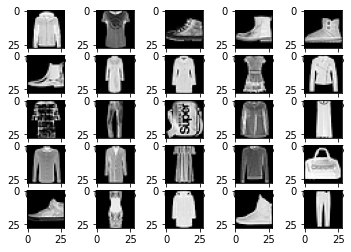

In [4]:
for i in range(25):
# define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [16]:
from tensorflow.keras.models import Model
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(filters=128, kernel_size=(3, 3),activation='selu',kernel_initializer="lecun_normal")(input)
x = layers.AveragePooling2D((2, 2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3),activation='selu',kernel_initializer="lecun_normal")(x)
x = layers.AveragePooling2D((2, 2), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=1024, activation='selu',kernel_initializer="lecun_normal")(x)
x= layers.Dense(784,activation='cm')(x)

# Decoder
x = layers.Reshape((28,28,1))(x)
x = layers.Conv2DTranspose(256, (3, 3), activation="selu", kernel_initializer="lecun_normal",padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(units=256, activation='selu',kernel_initializer="lecun_normal")(x)
x = layers.Dense(units=128, activation='selu',kernel_initializer="lecun_normal")(x)
x = layers.Conv2DTranspose(128, (3, 3), activation="selu", kernel_initializer="lecun_normal",padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid",padding='same')(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 average_pooling2d_20 (Avera  (None, 13, 13, 128)      0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_36 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 11, 11, 256)       295168    
                                                                 
 average_pooling2d_21 (Avera  (None, 6, 6, 256)        0   

In [17]:
autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_valid, x_valid),
)

Epoch 1/20
430/430 [==============================] - 18s 39ms/step - loss: 0.3239 - val_loss: 0.2794
Epoch 2/20
430/430 [==============================] - 16s 38ms/step - loss: 0.2695 - val_loss: 0.2726
Epoch 3/20
430/430 [==============================] - 16s 38ms/step - loss: 0.2633 - val_loss: 0.2579
Epoch 4/20
430/430 [==============================] - 17s 38ms/step - loss: 0.2602 - val_loss: 0.2561
Epoch 5/20
430/430 [==============================] - 17s 39ms/step - loss: 0.2579 - val_loss: 0.2563
Epoch 6/20
430/430 [==============================] - 17s 39ms/step - loss: 0.2562 - val_loss: 0.2550
Epoch 7/20
430/430 [==============================] - 17s 39ms/step - loss: 0.2550 - val_loss: 0.2539
Epoch 8/20
430/430 [==============================] - 17s 39ms/step - loss: 0.2542 - val_loss: 0.2504
Epoch 9/20
430/430 [==============================] - 17s 39ms/step - loss: 0.2529 - val_loss: 0.2507
Epoch 10/20
430/430 [==============================] - 17s 39ms/step - loss: 0.252

In [18]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [23]:
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = autoencoder.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

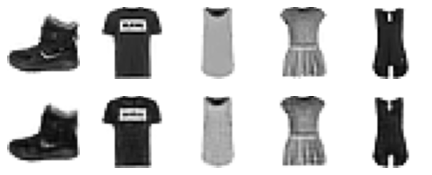

In [24]:
show_reconstructions(autoencoder)

In [25]:
x_train = autoencoder.predict(x_train)
# x_valid = stacked_ae.predict(x_valid)
# x_test = stacked_ae.predict(x_test)

In [26]:
x_valid = autoencoder.predict(x_valid)

__Clear the Backend__

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

__Piecewise Constant Scheduling__
* Added an additional learning constant
* A dynamic learning process

In [28]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 10:
        return 0.005
    elif epoch < 15:
        return 0.003
    elif epoch < 20:
        return 0.001
    else:
        return 0.0001

In [29]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn
piecewise_constant_fn = piecewise_constant([5,10,15,20,25], [0.01, 0.005,0.003,0.001,0.0001])

In [30]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

__Model Creation__

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3),padding="valid" ,
                              activation='selu',kernel_initializer="lecun_normal", input_shape=(28,28,1)))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3),padding="valid", 
                              activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.GaussianDropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=120, activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=84, activation='selu',kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(units=10, activation = 'softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 13, 13, 6)        0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 6)        24        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                        

In [33]:
# import visualkeras
# visualkeras.layered_view(model)

In [34]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, 'model.png', show_shapes=True)

__Model Compile__

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(clipvalue=1.0,clipnorm=1.0),metrics=["accuracy"])

__Model Fitting__

In [36]:
history = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=20,callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5801 - accuracy: 0.7901 - val_loss: 0.4694 - val_accuracy: 0.8362 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4643 - accuracy: 0.8312 - val_loss: 0.4104 - val_accuracy: 0.8470 - lr: 0.0100
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4337 - accuracy: 0.8403 - val_loss: 0.3555 - val_accuracy: 0.8704 - lr: 0.0100
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4162 - accuracy: 0.8476 - val_loss: 0.3569 - val_accuracy: 0.8688 - lr: 0.0100
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3961 - accuracy: 0.8559 - val_loss: 0.3121 - val_accuracy: 0.8834 - lr: 0.0100
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3443 - accuracy: 0.8725 - val_loss: 0.2980 - val_accuracy: 0.8938 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 8s

In [37]:
mse_test = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2791 - accuracy: 0.8957


In [38]:
x_test = autoencoder.predict(x_test)

In [39]:
mse_test = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2872 - accuracy: 0.8911


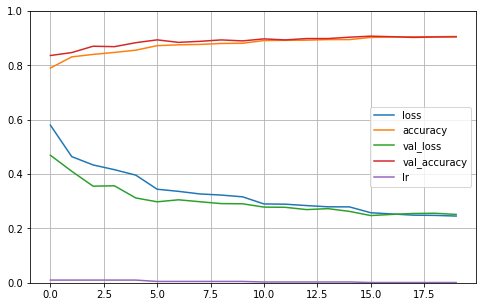

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

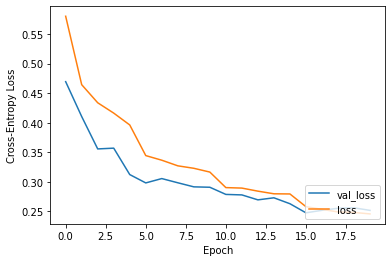

In [41]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='lower right')

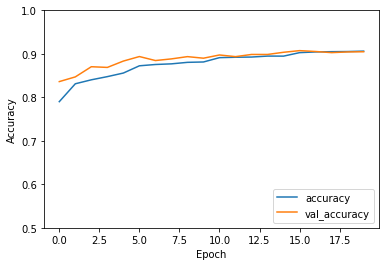

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [43]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1000
           1       1.00      0.97      0.98      1000
           2       0.86      0.79      0.82      1000
           3       0.89      0.92      0.90      1000
           4       0.81      0.83      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.66      0.76      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.99      0.97      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [44]:
import sklearn.metrics as sk
hl = sk.hamming_loss(y_test, y_pred)
js = sk.jaccard_score(y_test, y_pred,average=None)
bss = sk.balanced_accuracy_score(y_test,y_pred)
mcc = sk.matthews_corrcoef(y_test,y_pred)
print("Hamming Loss: "+ str(hl))
print("Jaccard index \n"+ "0\t" + str(js[0]) +"\n" +  "1\t" + str(js[1]) + "\n" + "2\t" + str(js[2])+"\n" + "3\t" + str(js[2]) + 
     "\n"+"4\t"+str(js[3]) + "\n"+"5\t"+str(js[4]) +"\n"+"6\t"+str(js[5]) + "\n"+"7\t"+str(js[6]) + "\n"+"8\t"+str(js[7])
     + "\n"+"9\t"+str(js[8]))
print("Balanced Accuracy Score: " + str(bss))
print("Matthews Correlation Coefficient: "+ str(mcc))

Hamming Loss: 0.1089
Jaccard index 
0	0.697239536954586
1	0.9671314741035857
2	0.6982300884955752
3	0.6982300884955752
4	0.8230008984725966
5	0.6957983193277311
6	0.9528949950932286
7	0.5442857142857143
8	0.9062792877225867
9	0.9595660749506904
Balanced Accuracy Score: 0.8911
Matthews Correlation Coefficient: 0.8792210835147909
